# 제주 핫플레이스 지도에 표시

## 데이터 준비

In [1]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving JejuHotPlace.csv to JejuHotPlace.csv


In [2]:
import pandas as pd
raw_df = pd.read_csv(filename)
raw_df.head()

,content,date,like,place,tags
0,더 늦기전에 제주도로 떠나쟈😍.#제주핫플레이스 간단히 1탄 모아봄!#제주여행 요 필...,2018-12-07,"1,402",NaN,"['#제주핫플레이스', '#제주여행', '#제주여행', '#제주도여행', '#제주가..."
1,12월에 제주도를 가야하는이유🍊.#제주핫플 모음 끝판왕😍이거 하나면 겨울 #제주여행...,2018-12-03,368,NaN,"['#제주핫플', '#제주여행', '#제주', '#제주도', '#제주도맛집', '#..."
2,11월 놓치지 말아야 할 제주 관광.가을바람이 최고조에 이르는 11월추운 겨울을 앞...,2018-11-02,166,NaN,"['#honestin', '#어니스틴', '#제주여행', '#제주', '#제주도',..."
3,국민학교세대#제주관광#제주살이#제주이주민#아라동주민#삼남매집 #새해첫날#드라이브#명...,2019-01-01,28,명월국민학교,"['#제주관광', '#제주살이', '#제주이주민', '#아라동주민', '#삼남매집'..."
4,#제주관광 #제주 #돔나이트 #스트레스 #풀자 #춤추며 #땀날려 #가끔은괜찮아 #인...,2019-01-01,12,NaN,"['#제주관광', '#제주', '#돔나이트', '#스트레스', '#풀자', '#춤추..."


In [3]:
location_counts = raw_df.place.value_counts().to_frame()
print(location_counts.shape)
location_counts.head()

(1027, 1)


,place
Jeju,241
Jeju-do,172
Jungle Book by Alice,101
Seogwipo,65
제주도 크리스마스 박물관,59


In [4]:
location_counts.tail()

,place
제주집,1
북촌플레이스,1
노형 수목원가는길,1
헤이브라더,1
자연뜨락,1


In [5]:
location_counts.to_csv('location_counts.csv')

In [7]:
loc_df = pd.read_csv('location_counts.csv')
loc_df.columns = ['지명', '빈도']
loc_df.head()

,지명,빈도
0,Jeju,241
1,Jeju-do,172
2,Jungle Book by Alice,101
3,Seogwipo,65
4,제주도 크리스마스 박물관,59


## 카카오 검색 API를 이용한 장소 검색

### 키워드 장소 검색

In [8]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving kakaoapikey.txt to kakaoapikey.txt


In [9]:
with open(filename) as f:
    api_key = f.read()

In [10]:
import requests
from urllib.parse import quote

In [12]:
keyword = '합정 스타벅스'
search_url = 'https://dapi.kakao.com/v2/local/search/keyword.json'
url = f'{search_url}?query={quote(keyword)}'
result = requests.get(url, headers = {'Authorization' : f'KakaoAK {api_key}'}).json()
result['documents'][0]

{'address_name': '서울 마포구 서교동 395-166',
 'category_group_code': 'CE7',
 'category_group_name': '카페',
 'category_name': '음식점 > 카페 > 커피전문점 > 스타벅스',
 'distance': '',
 'id': '26572121',
 'phone': '1522-3232',
 'place_name': '스타벅스 서교점',
 'place_url': 'http://place.map.kakao.com/26572121',
 'road_address_name': '서울 마포구 양화로 78',
 'x': '126.916980454434',
 'y': '37.5514601750423'}

In [21]:
import numpy as np
import re

In [55]:
def find_place(keyword):
    search_url = 'https://dapi.kakao.com/v2/local/search/keyword.json'
    url = f'{search_url}?query={quote(keyword)}'
    result = requests.get(url, headers = {'Authorization' : f'KakaoAK {api_key}'}).json()
    try:
        name = result['documents'][0]['place_name']
        if '제주특별자치도' not in result['documents'][0]['address_name']:
            lng = np.nan
            lat = np.nan
        else:
            lng = float(result['documents'][0]['x'])
            lat = float(result['documents'][0]['y'])
    except:
        name = ''
        lng = np.nan
        lat = np.nan
    return name, lng, lat, keyword

In [14]:
find_place('제주국제공항')

('제주국제공항', 126.492769004244, 33.5070789578184, '제주국제공항')

In [16]:
find_place('제주공항')

('제주국제공항', 126.492769004244, 33.5070789578184, '제주공항')

### loc_df에 공식명칭, 위도, 경도 정보 추가

In [56]:
name_list, lng_list, lat_list = [], [], []
for place in loc_df.지명:
    place = re.sub('[^가-힣0-9 ]', '', place).strip()
    if place:
        name, lng, lat, _ = find_place(place)
    else:
        name, lng, lat = '', np.nan, np.nan
    name_list.append(name)
    lng_list.append(lng)
    lat_list.append(lat)

In [57]:
loc_df['공식명칭'] = name_list
loc_df['위도'] = lat_list
loc_df['경도'] = lng_list
loc_df.head()

,지명,빈도,공식명칭,위도,경도
0,Jeju,241,,NaN,NaN
1,Jeju-do,172,,NaN,NaN
2,Jungle Book by Alice,101,,NaN,NaN
3,Seogwipo,65,,NaN,NaN
4,제주도 크리스마스 박물관,59,바이나흐튼 크리스마스박물관,33.291572,126.327858


#### Null 데이터 유무 확인

In [58]:
loc_df.isnull().sum()

지명        0
빈도        0
공식명칭      0
위도      304
경도      304
dtype: int64

In [59]:
loc_df.isna().sum()

지명        0
빈도        0
공식명칭      0
위도      304
경도      304
dtype: int64

#### Null 데이터 삭제

In [60]:
total_df = loc_df.dropna() # Null 값이 있는 행을 삭제
total_df.isnull().sum().sum() # 0이 나오면 Null 값이 없음

0

In [61]:
total_df.head()

,지명,빈도,공식명칭,위도,경도
4,제주도 크리스마스 박물관,59,바이나흐튼 크리스마스박물관,33.291572,126.327858
5,제주에인감귤밭,48,제주에인감귤밭,33.256561,126.539014
7,성산일출봉 城山日出峰 Seongsan Ilchulbong,36,성산일출봉,33.459135,126.940538
8,폼포코식당_pompokokitchen,30,폼포코식당,33.450408,126.919065
9,1100고지,25,한라산1100고지,33.358078,126.462220


#### 공식명칭 데이터 결합

In [62]:
total_df.공식명칭.value_counts()[:10]

올레길 7코스(서귀포-월평 올레)    6
함덕해수욕장                4
동문재래시장                4
세화해변                  3
제주중문관광단지              3
천지연폭포                 3
이호테우해수욕장              3
협재해수욕장                3
우도                    3
한라산국립공원               3
Name: 공식명칭, dtype: int64

In [63]:
df = total_df.pivot_table(index=['공식명칭', '위도', '경도'], values='빈도', aggfunc='sum')
df.head()

,,,빈도
공식명칭,위도,경도,
1158족욕카페,33.467075,126.336504,1
702키친,33.498835,126.534134,1
가드망제,33.500991,126.532954,1
가시식당,33.353060,126.771438,2
가시아방국수,33.438605,126.918065,3


In [64]:
df.reset_index(inplace=True)
df.공식명칭.value_counts()[:5]

서귀포의료원     1
국수바다 본점    1
명월국민학교     1
소금바치순이네    1
다람쥐식탁      1
Name: 공식명칭, dtype: int64

In [65]:
df.to_csv('공식명칭.csv', index=False)

## Folium Visualization

In [66]:
df.sort_values(by='빈도', ascending=False).head(10)

,공식명칭,위도,경도,빈도
190,바이나흐튼 크리스마스박물관,33.291572,126.327858,59
465,제주에인감귤밭,33.256561,126.539014,48
270,성산일출봉,33.459135,126.940538,38
574,폼포코식당,33.450408,126.919065,30
598,한라산1100고지,33.358078,126.462220,25
407,위미동백나무군락,33.272939,126.674731,24
405,월정리해수욕장,33.556469,126.795805,22
20,고집돌우럭 중문점,33.257981,126.416705,21
383,올레길 7코스(서귀포-월평 올레),33.237386,126.515310,21
614,함덕해수욕장,33.543062,126.669239,20


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)


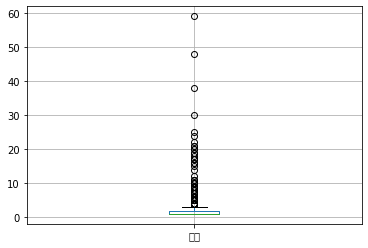

In [67]:
df[['빈도']].boxplot()

In [38]:
import folium

In [68]:
type(df.빈도[0])

numpy.int64

In [69]:
Mt_Hanla = [33.3625, 126.533694]
map = folium.Map(location = Mt_Hanla, zoom_start = 11)
for i in df.index:
    folium.CircleMarker(
        radius = int(df.빈도[i]),
        location = [df.위도[i], df.경도[i]],
        popup = folium.Popup(df.공식명칭[i], max_width = 200),
        tooltip = df.공식명칭[i],
        color = 'red'
    ).add_to(map)
title = '<h3 align="center" style="font-size:20px">Jeju Hot Place</h3>'
map.get_root().html.add_child(folium.Element(title))
map

In [70]:
map.save('JejuHotPlace(Individual).html')

### 그룹으로 표시

In [71]:
from folium.plugins import MarkerCluster
locations, names = [], []
for i in df.index:
    locations.append([df.위도[i], df.경도[i]])
    names.append(df.공식명칭[i])

In [72]:
map = folium.Map(location = Mt_Hanla, zoom_start = 11)
MarkerCluster(
    locations = locations, popups = names,
    name = '제주', overlay = True, control = True
).add_to(map)
title = '<h3 align="center" style="font-size:20px">Jeju Hot Place</h3>'
map.get_root().html.add_child(folium.Element(title))
map

In [73]:
map.save('JejuHotPlace(Group).html')